In [72]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance
!pip install fix_yahoo_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
#Importar modulos requeridos
import pandas_datareader as data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#Importar librerias de visualización
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# Ejemplo serie de tiempo con Pandas
# Creando una serie de tiempo de los precios de SP500
ts = data.DataReader("SPY", start='2018-1-1', end='2022-11-6', data_source='yahoo')['Adj Close']


In [75]:
ts.head()

Date
2018-01-02    247.899841
2018-01-03    249.467789
2018-01-04    250.519226
2018-01-05    252.188690
2018-01-08    252.649902
Name: Adj Close, dtype: float64

# **Dividir en train y test**

In [76]:
train, test = train_test_split(ts, test_size=0.3, shuffle=False)

In [77]:
train.shape

(854,)

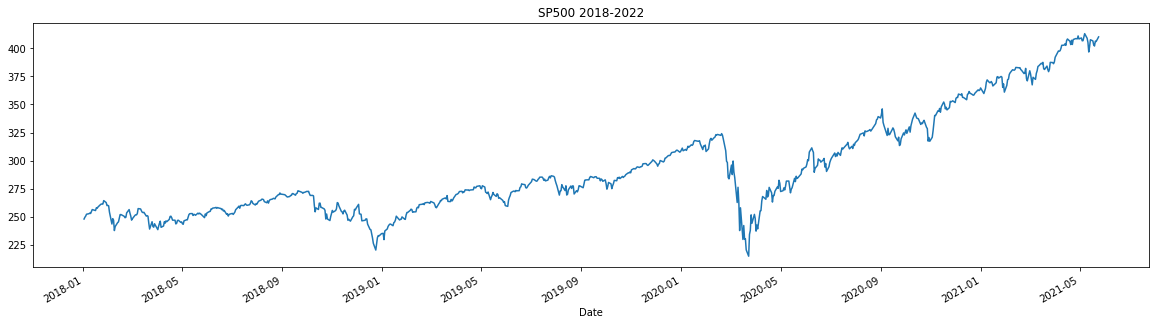

In [78]:
#Visualizamos los datos train
plt.figure(figsize=(20,5))
train.plot()
plt.title('SP500 2018-2022')
plt.show()

# **Revisar autocorrelaciones**

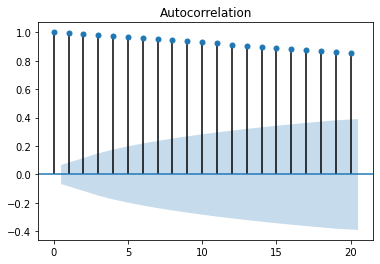

In [79]:
#Importamos el modulo de statsmodels para autocorrelación
from statsmodels.graphics.tsaplots import plot_acf
#Importamos el modulo de Pandas para autocorrelación
from pandas.plotting import autocorrelation_plot


#Graficamos la autocorrelación de la serie
fig = plot_acf(train, lags=20, alpha=0.05)


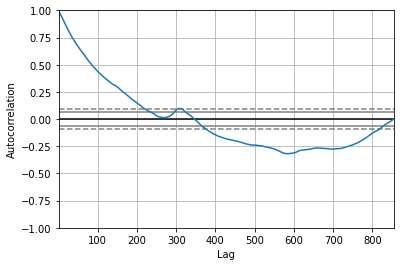

In [80]:
autocorrelation_plot(train)

In [81]:
train.autocorr(lag=30)

0.9090779128507935

**Se observa una alta autocorrelación en la serie de SP500, en los primeros 30 lags sobrepasa el 0.90**

# **Determinar si la serie es ruido blanco**

**Inicialmente vemos que la media de la serie no es cercana a cero.**

In [82]:
train.describe()

count    854.000000
mean     292.585948
std       45.278223
min      214.767181
25%      257.956978
50%      276.708008
75%      317.546547
max      413.148132
Name: Adj Close, dtype: float64

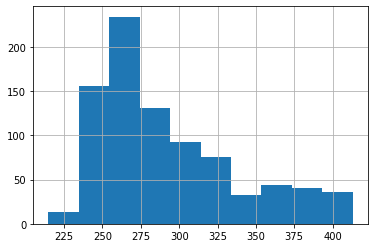

In [83]:
train.hist()

In [84]:
media_movil = train.rolling(window=20).mean()
std_movil = train.rolling(window=20).std()
banda_sup = media_movil + 2 * std_movil
banda_inf = media_movil - 2 * std_movil

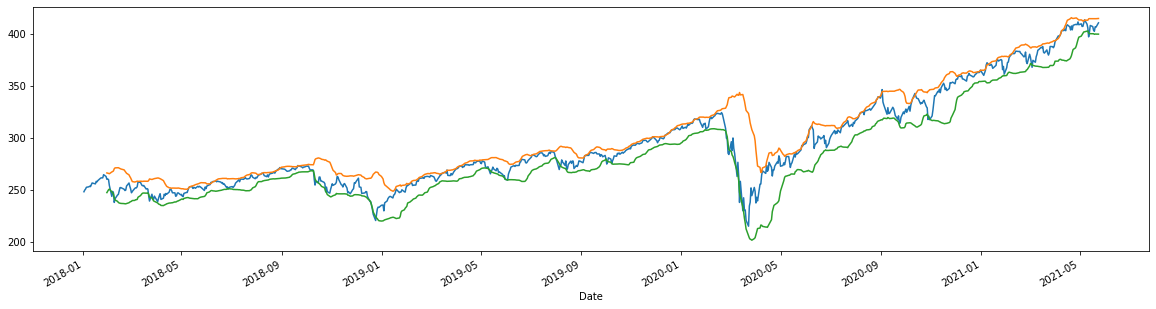

In [85]:
plt.figure(figsize=(20,5))
train.plot()
banda_sup.plot()
banda_inf.plot()
plt.show()

**Como se observaba en el punto anterior la autocorrelación es alta, la media no es cercana a cero y su varianza no es constante.** 

**En conclusión la serie SP500 no es una serie white noise.**


# **Determinar si la serie es random walk**

# **Descomponerla en trend, seasonality y residuos(usando la biblioteca)**

In [86]:
#Importamos el modulo de statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

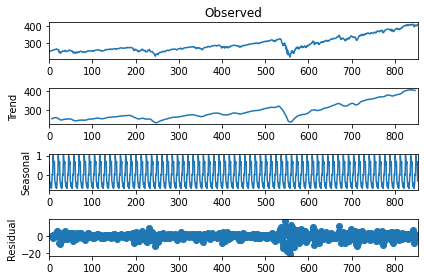

In [87]:
# Ejemplo de descomposición de serie de tiempo
descompose= seasonal_decompose(train.values, period=12)

#Graficamos...
descompose.plot()
plt.show()

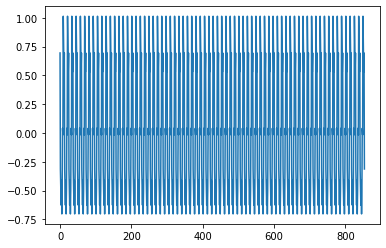

In [88]:
#Graficamos la estacionalidad
plt.plot(descompose.seasonal)
plt.show()

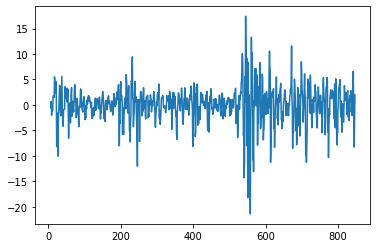

In [89]:
#Graficamos el residuo
plt.plot(descompose.resid)
plt.show()

# **Determinar si la serie es estacionaria**

In [90]:
from statsmodels.tsa.stattools import adfuller

In [91]:
p = adfuller(train)[1]
p

0.9570703549296085

**No es estacionaria la serie SP500**

Ho (No es estacionaria) p > 0.05

H1 (Es estacionaria) p < 0.05

# **Método de diferencias**

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [93]:
t = np.arange(len(train))
y = train.values

In [94]:
poly = PolynomialFeatures(degree=4)
t2 = poly.fit_transform(t.reshape(-1, 1))


In [95]:
model = LinearRegression()
model.fit(t2, y)

LinearRegression()

In [96]:
trend = model.predict(t2) # trend = model.coef[0] * t2[1] + model.coef[1] * t2[2] + model.intercept_ 

In [97]:
z = train.values - trend

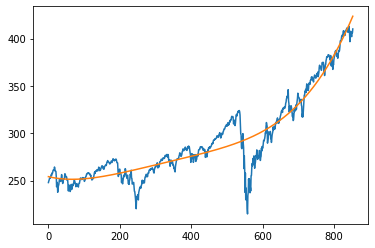

In [98]:
plt.plot(train.values)
plt.plot(trend)

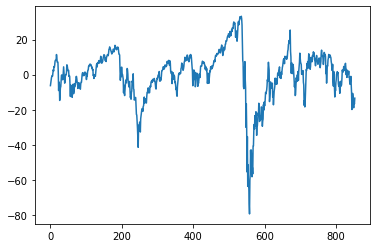

In [99]:
plt.plot(z)

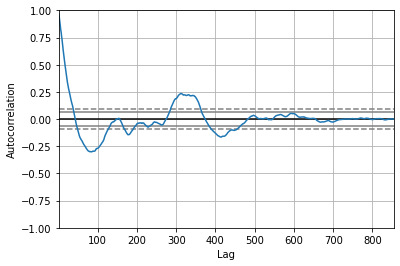

In [100]:
autocorrelation_plot(z)

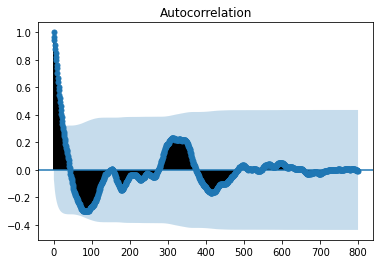

In [101]:
fig = plot_acf(z, lags=799 , alpha=0.05)
fig.show()

In [103]:
p = adfuller(z)[1]
p

0.0010103827846170608